In [299]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import random
from numba import jit
import time
import dask 
from dask import delayed
from collections import deque
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import pandas as pd

In [300]:
import plotly.express as px

Effective stimulus ( $v$ ) follows the Michaelis-Menten Equation:

$$ v = \frac{ v_{max} * S }{ K_d + S} $$

Where:
$v_{max}$ is the maximum possible effective stimulus defined as a funciton of the number of 
receptors ( $nR$ ) a cell has and the catalytic rate constant (degradation rate per receptor) ($K_{cat}$)

default: 
- $ nR = 100$ 
- $k_{cat} = 0.4$ 

$K_d = \frac{k_{off} } {k_{on} }$, defined as a global variables in simulation portion of the code

$S$ is the chemoattractant concentration



In [301]:
def getEffectiveStimulus(v_max, S, K_d):
    '''
    Calculates the effective stimulus (or degree to which the cell is affected by a chemoattractant) 
    according to the relative concentration of the chemoattractant of the cell as well as 
    it's saturation coefficient and the Michaelis-Menten constant.

    Parameters:
        cell (Cell): The cell object to calculate the effective stimulus for where 
            cell.v_max is the maximum reaction of the cell which is determined by the number of 
            receptors the cell is instantiateed with as well as single receptor sensitivity, also
            defined on cell instantiation,
        S (float): The concentration of the chemoattractant at the cell's position.
        K_d (float): The Michaelis-Menten constant defined by k_off / k_on which are 
            defined as global variables 
    
    Returns:
        v (float): The effective stimulus
    '''
    
    v = (v_max * S) / (K_d + S)
    return v

In [302]:
def circle_points(center, radius):
    """
    Calculate all points within a circle in a 2D grid using a rasterization approach,
    returning the points as an array of arrays.

    Parameters:
        center (tuple): The (x, y) coordinates of the circle's center.
        radius (int): Radius of the circle.
    
    Returns:
        list: A list of [x, y] points inside the circle.
    """
    cx, cy = center
  #  radius_squared = radius ** 2
    points = []

    # Use the midpoint circle algorithm to find points
    x, y = radius, 0
    decision = 1 - radius

    while x >= y:
        # Add the points for each octant of the circle as lists
        points.extend([
            [cx + x, cy + y], [cx - x, cy + y], [cx + x, cy - y], [cx - x, cy - y],
            [cx + y, cy + x], [cx - y, cy + x], [cx + y, cy - x], [cx - y, cy - x]
        ])

        y += 1
        if decision <= 0:
            decision += 2 * y + 1
        else:
            x -= 1
            decision += 2 * (y - x) + 1

    # Filter points to ensure they are within the bounds of the grid (optional)
    points = [list(item) for item in set(tuple(point) for point in points)]  # Remove duplicates
    return np.array(points)

In [303]:
@jit(nopython=True)
def _compute_gradient(pos_x, pos_y, u, dx, dy, step = 1):
    '''
    Compute the gradient of a field u at a given position (pos_x, pos_y) using central differences.
    Intended to be used within a wrapped function defined as part of the cell class.
    This version is defined outside the class to allow for the use of numba's JIT compiler.

    Parameters:
        pos_x (int): The x-coordinate of the position.
        pos_y (int): The y-coordinate of the position.
        u (numpy.ndarray): The field to compute the gradient of.
        dx (float): The grid spacing in the x-direction.
        dy (float): The grid spacing in the y-direction.
        step (int): The step size for the gradient computation.

    Returns:
        numpy array: A tuple containing the x and y components of the gradient.
    '''
    x, y = pos_x, pos_y 

    # Compute central difference gradient
    if 1 <= x < u.shape[0] - 1 and 1 <= y < u.shape[1] - 1: # boundary rejection

        grad_x = (u[x+step, y] - u[x-step, y]) / (2 * dx) # x grad
        grad_y = (u[x, y+step] - u[x, y-step]) / (2 * dy) # y grad
    
    else:
        grad_x, grad_y = 0, 0 
    
    return grad_x, grad_y

In [304]:
def degrade_pos_gen(center_x, center_y, side_length, grid_shape): 
    '''
    Function intended to run a single time. Calculates the area of degradation for a given cell perimeter.
    The area is updated as the cell moves using the same movement vector as the cell.
    
    Parameters:
        center_x (int): The x-coordinate of the center of the cell.
        center_y (int): The y-coordinate of the center of the cell.
        side_length (int): The side length of the square area to be degraded.
        grid_shape (tuple): The shape of the grid as (height, width).
    
    Returns:
        numpy.ndarray: An array of shape (N, 2) where N is the number of positions in the degraded area.
        Each row contains the (x, y) coordinates of a position within the degraded area.
    '''

    grid_h, grid_w = grid_shape

    str_x = max(0, center_x - side_length // 2)
    end_x = min(grid_w, center_x + side_length // 2 + 1)

    str_y = max(0, center_y - side_length // 2) 
    end_y = min(grid_h, center_y + side_length // 2 + 1)   

    x = np.arange(str_x, end_x)
    y = np.arange(str_y, end_y)

    x_mesh, y_mesh = np.meshgrid(x, y)

        # Stack x and y coordinates into a single array
    positions = np.vstack((x_mesh.ravel(), y_mesh.ravel())).T
    
    return positions

In [305]:
class Cell_2():
    """
    This class represents a cell in a grid environment. The cell can move, secrete attractants, and respond to gradients.
    It keeps track of its position and stimulation history.

    Attributes:
        v_max (float): Maximum velocity of the cell.
        default (bool): Indicates if the cell has a default shape.
        degRadius (int): Radius of the degradation area.
        degArea (np.ndarray): Degradation area positions.
        secrete (bool): Indicates if the cell secretes attractants.
        points (np.ndarray): Points representing the cell's shape.
        shape (str): Shape of the cell.
        pos_x (int): X-coordinate of the cell's centroid position.
        pos_y (int): Y-coordinate of the cell's centroid position.
        pos_history (deque): History of the cell's positions.
        RS_history (deque): History of the cell's stimulation and gradient responses.
    """

    def __init__(self, grid, pos_x, pos_y, shape=["circle", 1], degradation_area=1, nR=100, k_cat=0.4, secretion=False):
        """
        Initializes the Cell_2 object with the given parameters.

        Args:
            grid (np.ndarray): The grid environment.
            pos_x (int): Initial x-coordinate of the cell.
            pos_y (int): Initial y-coordinate of the cell.
            shape (list): Shape of the cell, default is ["circle", 1].
            degradation_area (int): Radius of the degradation area.
            nR (int): Number of receptors.
            k_cat (float): Catalytic rate constant.
            secretion (bool): Indicates if the cell secretes attractants.
        """
        self.v_max = nR * k_cat
        self.default = True
        self.degRadius = degradation_area
        self.degArea = degrade_pos_gen(pos_x, pos_y, degradation_area, grid.shape)
        self.secrete = secretion

        if shape[0] == "circle" and shape[1] > 1:
            self.default = False
            self.points = circle_points((pos_x, pos_y), shape[1])
        else:
            self.points = np.array([[pos_x, pos_y]])
            
        self.shape = shape[0]
        self.pos_x = int(pos_x)
        self.pos_y = int(pos_y)
        self.pos_history = deque()
        self.pos_history.append([0, self.pos_x, self.pos_y])

        self.RS_history = deque()

    def update_pos(self, grid_size, step=1):
        """
        Updates the position of the cell randomly within the grid boundaries.

        Args:
            grid_size (int): Size of the grid.
            step (int): Step size for the random movement.
        """
        if self.default:
            self.pos_x = np.clip(self.pos_x + np.random.randint(-step, step), 0, grid_size - 1)
            self.pos_y = np.clip(self.pos_y + np.random.randint(-step, step), 0, grid_size - 1)
        else:
            self.points = np.clip(self.points + [np.random.randint(-step, step), np.random.randint(-step, step)], 0, grid_size - 1)

    def attractant_secretion_rule(self, rule="random"):
        """
        Determines if the cell secretes an attractant based on a random or user defined rule.

        Args:
            rule (str): Rule for secretion, default is "random".

        Returns:
            bool: True if the cell secretes an attractant, False otherwise.
        """
        if random.uniform(0, 1) < 0.001:
            return True
        else:
            return False

    def compute_gradient(self, u, dx, dy, step=1):
        """
        Computes the gradient at the cell's position.

        Args:
            u (np.ndarray): Concentration field.
            dx (float): Grid spacing in the x-direction.
            dy (float): Grid spacing in the y-direction.
            step (int): Step size for the gradient computation.

        Returns:
            tuple: Gradient in the x and y directions.
        """
        grad_x, grad_y = _compute_gradient(self.pos_x, self.pos_y, u, dx, dy, step)
        return grad_x, grad_y

    def update_pos_grad(self, u, dx, dy, sensitivity, time_curr, dt, grid_shape, step=1):
        """
        Updates the position of the cell based on the gradient and random movement.

        Args:
            u (np.ndarray): Concentration field.
            dx (float): Grid spacing in the x-direction.
            dy (float): Grid spacing in the y-direction.
            sensitivity (float): Sensitivity of the cell to the gradient.
            time_curr (float): Current time.
            dt (float): Time step.
            grid_shape (tuple): Shape of the grid.
            step (int): Step size for the random movement.
        """
        global K_d
        grad_x, grad_y = self.compute_gradient(u, dx, dy)

        # Random movement with gradient influence
        rand_x = random.randint(-step, step)
        rand_y = random.randint(-step, step)

        v_max = self.v_max

        S = u[self.pos_x, self.pos_y]
        v = getEffectiveStimulus(v_max, S, K_d)

        sensitivity = v / v_max  # Sensitivity is defined as the ratio of the effective stimulus to the maximum stimulus

        self.RS_history.append([time_curr + dt, v, (grad_x + grad_y) / 2])

        # Generate movement vector
        move_x = int(rand_x + grad_x * sensitivity)
        move_y = int(rand_y + grad_y * sensitivity)

        # Apply the movement to all points
        mov_vector = np.array([move_y, move_x])
        self.points += mov_vector
        self.pos_x += move_x
        self.pos_y += move_y

        self.degArea += mov_vector

        # Boundary values
        x_min, x_max = 0, grid_shape[0] - 1
        y_min, y_max = 0, grid_shape[1] - 1

        # Find points outside the grid
        outside_points = self.points[
            (self.points[:, 0] < x_min) | (self.points[:, 0] > x_max) |
            (self.points[:, 1] < y_min) | (self.points[:, 1] > y_max)
        ]

        if outside_points.size > 0:
            # Compute correction vector as the negative sum of out-of-bounds offsets
            correction_vector = np.array([
                -np.sum(outside_points[:, 0] - np.clip(outside_points[:, 0], x_min, x_max)),
                -np.sum(outside_points[:, 1] - np.clip(outside_points[:, 1], y_min, y_max))
            ])

            # Apply correction to all points and the center
            self.points += correction_vector
            self.pos_x += correction_vector[1]
            self.pos_y += correction_vector[0]

            self.degArea += correction_vector

        # Append the position to history
        self.pos_history.append([time_curr + dt, self.pos_x, self.pos_y])

    def get_position_history(self, type="list"):
        """
        Returns the position history of the cell.

        Args:
            type (str): Format of the returned history, can be "list", "df", or "dict".

        Returns:
            list/pd.DataFrame/dict: Position history in the specified format.
        """
        if type == "list":
            return list(self.pos_history)
        elif type == "df":
            df = pd.DataFrame(list(self.pos_history), columns=["time_step", "pos_x", "pos_y"])
            return df
        elif type == "dict":
            return {"time_step": [x[0] for x in self.pos_history], "pos_x": [x[1] for x in self.pos_history], "pos_y": [x[2] for x in self.pos_history]}

    def get_stimulation_stats(self, type="list"):
        """
        Returns the stimulation and gradient response history of the cell.

        Args:
            type (str): Format of the returned history, can be "list", "df", or "dict".

        Returns:
            list/pd.DataFrame/dict: Stimulation and gradient response history in the specified format.
        """
        if type == "list":
            return list(self.RS_history)
        elif type == "df":
            df = pd.DataFrame(list(self.RS_history), columns=["time_step", "effective_stimulus", "gradient_magnitude"])
            return df
        elif type == "dict":
            return {"time_step": [x[0] for x in self.RS_history], "effective_stimulus": [x[1] for x in self.RS_history], "gradient_magnitude": [x[2] for x in self.RS_history]}


In [306]:
# PARAMETERS
"""
This script sets up parameters and initial conditions for a simulation.

Parameters:
    k_on (float): Rate constant for the binding reaction (M^-1 s^-1).
    k_off (float): Rate constant for the unbinding reaction (s^-1).
    K_d (float): Dissociation constant (K_d).
    alpha (float): Thermal diffusivity.
    length (int): Length of the simulation domain.
    sim_time (int): Total simulation time.
    nodes (int): Number of nodes in each dimension of the simulation grid.
    num_cells (int): Number of cells in the simulation.
    dx (float): Grid spacing in the x-direction.
    dy (float): Grid spacing in the y-direction.
    dt (float): Time step size, defined by von neurmann stability criterion.
    t_nodes (int): Number of time steps.
    u (ndarray): 2D array representing the temperature field.
    array_len (int): Length of the temperature array.
    max_temp (int): Maximum temperature value.
    center_x (int): x-coordinate of the center of the high temperature region.
    center_y (int): y-coordinate of the center of the high temperature region.
    radius (int): Radius of the high temperature region.
"""

k_on = 2e2  # M^-1 s^-1#
k_off = 10e4 # s^-1

K_d = k_off / k_on # M

alpha = 5
length = 400
sim_time = 100
nodes = 250
num_cells= 8

dx = length / nodes
dy= length / nodes


dt = min(dx**2 / (4*alpha), dy**2 / (4*alpha))

t_nodes = int(sim_time/dt)

u = np.zeros((nodes, nodes))


array_len = len(u)

max_temp = 100

u[:,-1:-10] = max_temp
#u[:,int(nodes*0.75):]= max_temp
u[0:50,:] = max_temp
#u[ int(len(u)/2): int(len(u)/2)] = 100

center_x, center_y = nodes // 2, nodes // 2
radius = 15  # Radius of high temperature region

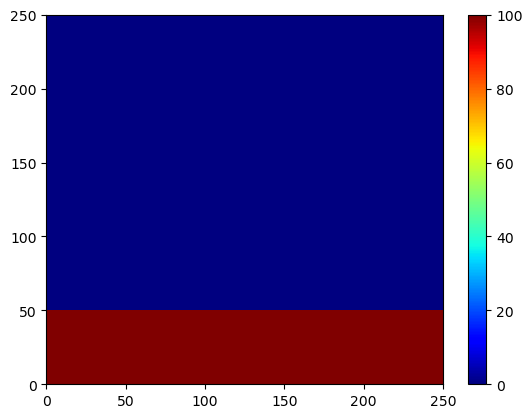

In [307]:
#Set up initial plot 
fig, axis = plt.subplots()
pcm = axis.pcolormesh(u, cmap = plt.cm.jet, vmin=0, vmax=100)
plt.colorbar(pcm, ax=axis)


In [308]:
# Generate initial cells, empty list to store cell markers and counter to keep track of simulation time
cells = [Cell_2( u, int(nodes/ 2), int( nodes / 2), shape= ["circle", 3], degradation_area = 5) for _ in range(num_cells)]
counter = 0 
cellMarker = []

In [309]:
@jit(nopython=True)
def calc_grad_np(u):
    """
    Calculate the gradient using NumPy arrays with JIT compilation.

    This function computes the gradient of a 2D array `u` using finite difference 
    methods and updates the array `w` accordingly. The function is optimized 
    using Numba's JIT compilation for improved performance.

    Parameters:
    u (numpy.ndarray): 2D array representing the input data.

    Returns:
    numpy.ndarray: 2D array `w` with the computed gradient values.
    """
    w = u.copy()
    w[1:-1, 1:-1] = (
        u[1:-1, 1:-1]
        + alpha * dt * (
            (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2
            + (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2
        )
    )
    return w

In [310]:
@delayed
def update_cell(c, u, dx, dy, counter, dt, grid_size):
    """
    - Parallel Process via Dask's delayed decorator
    
    Update the position and state of a cell in a grid.
    This function updates the position of a cell based on its gradient and modifies the grid values 
    based on the cell's degradation radius and area. If the degradation radius is greater than 1, it clips 
    the degradation area to the grid boundaries and reduces the grid values in the degradation area. 
    Otherwise, it reduces the grid value at the cell's position.
    Parameters:
    c (Cell): The cell object to be updated.
    u (np.ndarray): The grid representing the environment.
    dx (float): Distance to each nodes in x direction.
    dy (float): Distance to each nodes in x direction.
    counter (int): A counter used in the update process.
    dt (float): The time step for the update.
    grid_size (tuple): The size of the grid (height, width).
    Returns:
    Cell: The updated cell object.
    """    
    c.update_pos_grad(u, dx, dy, 0.5, counter, dt, grid_size)

    if c.degRadius > 1:
        x_min, x_max = 0, u.shape[1] - 1
        y_min, y_max = 0, u.shape[0] - 1

        clipped_degArea = np.copy(c.degArea)
        clipped_degArea[:, 0] = np.clip(clipped_degArea[:, 0], y_min, y_max)  # Y-axis
        clipped_degArea[:, 1] = np.clip(clipped_degArea[:, 1], x_min, x_max)  # X-axis

        u[clipped_degArea[:,1], clipped_degArea[:,0]] = u[clipped_degArea[:,1], clipped_degArea[:,0]] / 10
    else:
        u[c.pos_x, c.pos_y] =  u[c.pos_x, c.pos_y] / 10
    return c

In [311]:
start = time.time() # For measuring simulation time

while counter < sim_time : 

    w = u.copy()
    if cellMarker:
        for mark in cellMarker: 
            mark.remove()

    u = calc_grad_np(u)            
    
    tasks = [ delayed (update_cell)(c, u, dx, dy, counter, dt, u.shape) for c in cells ]    
    results = dask.compute(*tasks)

    #pcm.set_array(u) # Optional for plotting live
    #axis.set_title("Distribution at t: {:.3f} [s].".format(counter)) # Optional for plotting live

    #cellMarker = [axis.plot(cell.pos_y, cell.pos_x, 'wo', markersize=8)[0] for cell in cells]  #Optional for plotting live

 
    #plt.pause(0.01)
    counter += dt
    
end = time.time()

FINAL = end - start

print(f'Total Execution Time: {FINAL}')

Total Execution Time: 1.6402032375335693


In [312]:
test_cell = cells[0]

In [313]:
df = test_cell.get_stimulation_stats("df")

In [315]:
df.corr()

,time_step,effective_stimulus,gradient_magnitude
time_step,1.000000,0.363743,-0.085437
effective_stimulus,0.363743,1.000000,-0.296210
gradient_magnitude,-0.085437,-0.296210,1.000000


In [316]:
test_cell1 = cells[0].get_position_history(type="df")

In [317]:
test_cell1

,time_step,pos_x,pos_y
0,0.000,125,125
1,0.128,124,126
2,0.256,123,126
3,0.384,122,125
4,0.512,123,126
...,...,...,...
778,99.584,55,213
779,99.712,55,213
780,99.840,55,214
781,99.968,54,215


In [318]:
cell_0_pos_history = np.array(cells[0].get_position_history())
cell_1_pos_history = np.array(cells[1].get_position_history())
cell_2_pos_history = np.array(cells[2].get_position_history())
cell_3_pos_history = np.array(cells[3].get_position_history())


In [319]:
def plot_cell_history(cell_history):
    """
    Plots the trajectory of a single cell's movement over time with a gradient line colored by time steps.

    Parameters:
    cell_history (numpy.ndarray): A 2D array where each row represents a time step and contains the following columns:
                                  [time_step, y_position, x_position]

    The function creates a plot showing the cell's movement trajectory, with the line color representing the time step.
    The start and end points of the trajectory are annotated with green and red markers, respectively.
    """
    time_steps = cell_history [:,0]
    x_pos = cell_history [:,2]
    y_pos = cell_history [:,1]

    points = np.array([x_pos, y_pos]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.gca().add_collection(lc)
    plt.plot(x_pos, y_pos, color='black', alpha=0.1)
    # Annotate start and end
    plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)
    plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)

    plt.colorbar(lc, label='Time Step')
    plt.title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.legend()
    plt.show()

In [320]:

def plot_history_2(position_history, ax=None, color=None, cmap='viridis', label='Cell Path'):
    """
    Plots the trajectory of cell movement with a gradient line colored by time steps.
    Parameters:
    -----------
    position_history : numpy.ndarray
        A 2D array where each row represents a time step and contains [time, y_position, x_position].
    ax : matplotlib.axes.Axes, optional
        An existing matplotlib Axes object to plot on. If None, a new figure and axes are created.
    color : str or None, optional
        Color for the base path with markers. If None, the default color is used.
    cmap : str, optional
        Colormap to use for the gradient line. Default is 'viridis'.
    label : str, optional
        Label for the cell path. Default is 'Cell Path'.
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The matplotlib figure object.
    ax : matplotlib.axes.Axes
        The matplotlib axes object.
    lc : matplotlib.collections.LineCollection
        The LineCollection object representing the gradient line.
    Notes:
    ------
    The function creates a gradient line plot where the color of the line represents the time steps.
    It also annotates the start and end points of the trajectory.
    """
 
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Extract time steps, x positions, and y positions
    time_steps = position_history[:, 0]
    x_positions = position_history[:, 2]
    y_positions = position_history[:, 1]

    # Create segments for LineCollection
    points = np.array([x_positions, y_positions]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.plot(x_positions, y_positions, color=color, alpha=0.3)  # Base path with markers for reference

    # Annotate start and end
    ax.scatter(x_positions[0], y_positions[0], label='Start', zorder=5)
    ax.scatter(x_positions[-1], y_positions[-1], label='End', zorder=5)

    ax.set_title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    ax.legend()

    return fig, ax, lc

### Example Cell Trajectory Visualisation

/var/folders/_4/kt858wtj2111y2396_n7rtsm0000gn/T/ipykernel_37290/2067441439.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



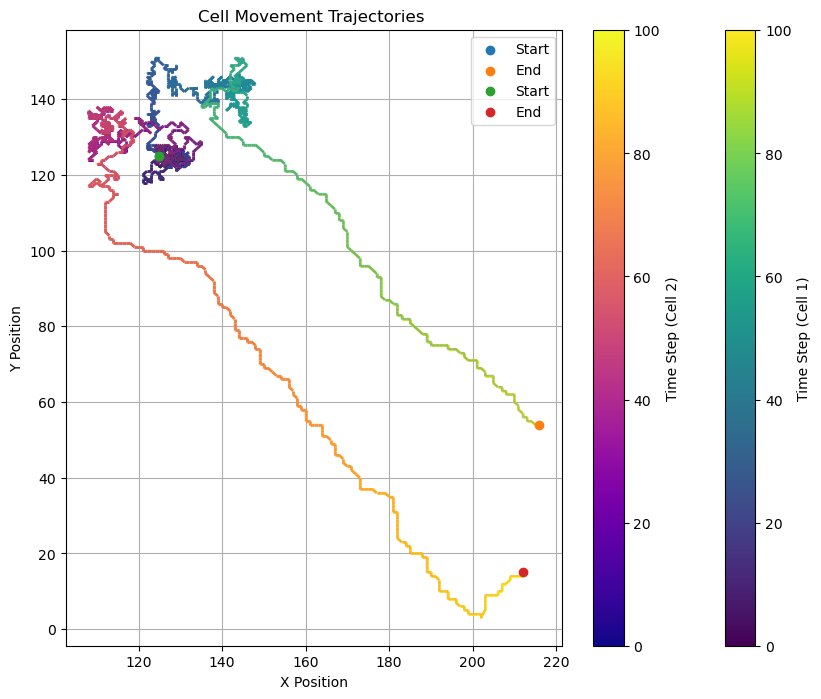

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
"""
This script visualizes the movement trajectories of cells using matplotlib.
The script performs the following steps:
1. Creates a figure and axis for plotting.
2. Defines the trajectories of cells to be plotted.
3. Determines the number of trajectories and sets up a colormap.
4. Iterates over each trajectory, plotting it with a specific colormap and adding a colorbar.
5. Adds a legend and title to the plot, then displays it.
Functions:
- plot_history_2: A function that plots the history of a cell's position on the given axis with the specified colormap.
Variables:
- fig: The figure object for the plot.
- ax: The axis object for the plot.
- trajectories: A list containing the position histories of the cells.
- num_trajectories: The number of trajectories to be plotted.
- colors: The colormap for the trajectories.
- colormaps: A list of colormaps to be used for each trajectory.
- idx: The index of the current trajectory in the loop.
- traj: The current trajectory being plotted.
- lc: The LineCollection object returned by the plot_history_2 function.
- cbar: The colorbar object for the current trajectory.
"""

trajectories = [cell_0_pos_history, cell_1_pos_history]

num_trajectories = len(trajectories)
colors = cm.get_cmap('hsv', num_trajectories)


colormaps = ['viridis', 'plasma']

for idx, traj in enumerate(trajectories):
    fig, ax, lc = plot_history_2(traj, ax=ax, cmap=colormaps[idx], label=f'Cell {idx + 1}')
    cbar = plt.colorbar(lc, ax=ax, label=f'Time Step (Cell {idx + 1})')
    cbar.set_label(f'Time Step (Cell {idx + 1})')
    
ax.legend()
plt.title("Cell Movement Trajectories ")
plt.show()

#### Single execution of plot_cell_history funciton

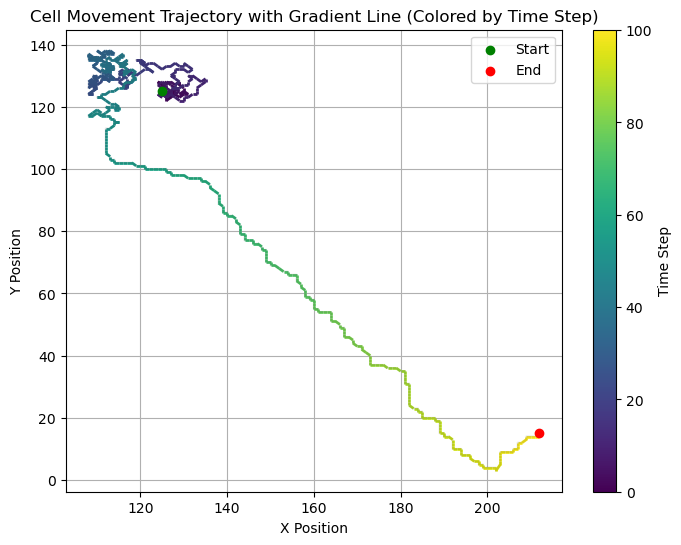

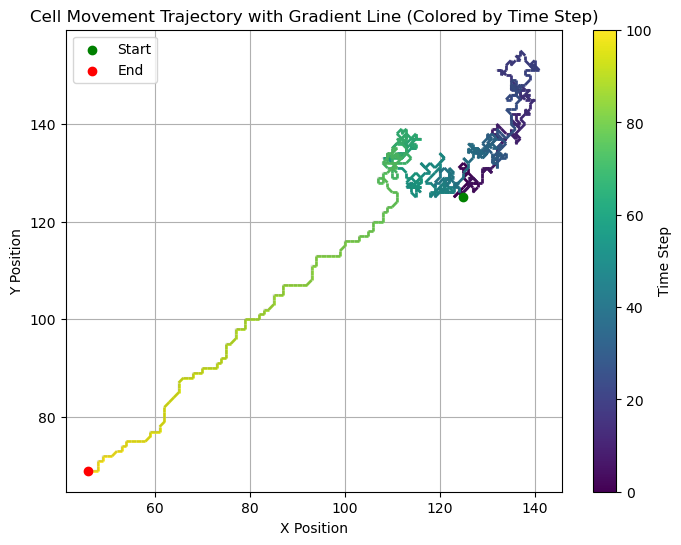

In [ ]:
plot_cell_history(cell_1_pos_history)
